In [1]:
import networkx as nx
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gym
from gym import spaces
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import deque

# Static Data for VNFs
VNF_Info = {
    1: ['NAT', 2, 'S'],
    2: ['FW', 1, 'M'],
    3: ['TM', 1, 'S'],
    4: ['WOC', 2, 'M'],
    5: ['IDPS', 4, 'S'],
    6: ['VOC', 4, 'M'],
    7: ['VPN', 2, 'M'],
    8: ['LB', 2, 'M'],
    9: ['DPI', 4, 'S'],
    10: ['P', 1, 'M'],
    11: ['TS', 2, 'M'],
    12: ['C', 4, 'S'],
    13: ['SFW', 1, 'S'],
    14: ['EFW', 4, 'M']
}

# Static Data for SFCs
SFC_Chains = [
    [1, 2, 3, 4, 5],
    [1, 2, 3, 2, 1],
    [1, 2, 3, 6, 5],
    [1, 2, 6, 4, 5],
    [7, 3, 2, 8],
    [14],
    [14, 8],
    [14, 8, 2],
    [4, 13, 8, 2],
    [4, 14, 3, 8, 2],
    [13, 8, 3, 2]
]

# Generate the Physical Network
def generate_physical_network(static_data):
    network = {}
    for node_id, attributes in static_data.items():
        network[node_id] = {
            'remaining_capacity': attributes['initial_capacity'],
            'security_level': attributes['initial_security_level'],
            'cost': attributes['initial_cost'],
            'deployed_vnfs': []  # To track deployed VNFs
        }
    return network



In [2]:

# Calculate communication latency between two nodes
def calculate_latency(node_a, node_b):
    return np.abs(node_a - node_b) * random.uniform(0.1, 0.5)

# Generate the SFCs with specific security requirements
def generate_sfc():
    sfc = []
    num_vnfs = random.randint(2, 5)
    for i in range(num_vnfs):
        vnf = {
            'vnf_id': i,
            'required_security_level': random.randint(1, 10),
            'processing_demand': random.randint(10, 100)
        }
        sfc.append(vnf)
    return sfc

# Define the Actor network for DDPG
class ActorNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=128):
        super(ActorNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, state):
        x = self.relu(self.fc1(state))
        x = self.relu(self.fc2(x))
        return self.tanh(self.fc3(x))

# Define the Critic network for DDPG
class CriticNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=128):
        super(CriticNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)
        self.relu = nn.ReLU()

    def forward(self, state, action):
        x = torch.cat([state, action], dim=1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.fc3(x)

In [3]:

# Ornstein-Uhlenbeck Noise for exploration
class OUNoise:
    def __init__(self, action_dim, mu=0, theta=0.2, sigma=0.2):
        self.action_dim = action_dim
        self.mu = mu
        self.theta = theta
        self.sigma = sigma
        self.reset()

    def reset(self):
        self.state = np.ones(self.action_dim) * self.mu

    def evolve_state(self):
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.action_dim)
        self.state = x + dx
        return self.state

    def get_noise(self):
        return self.evolve_state()

# Replay Buffer to store transitions
class ReplayBuffer:
    def __init__(self, max_size=100000):
        self.buffer = []
        self.max_size = max_size
        self.ptr = 0

    def add(self, transition):
        if len(self.buffer) < self.max_size:
            self.buffer.append(transition)
        else:
            self.buffer[self.ptr] = transition
        self.ptr = (self.ptr + 1) % self.max_size

    def sample(self, batch_size):
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        return [self.buffer[i] for i in indices]

# DDPG Agent class
class DDPGAgent:
    def __init__(self, state_dim, action_dim, hidden_dim=128, actor_lr=1e-3, critic_lr=1e-3, gamma=0.99, tau=0.005):
        self.actor = ActorNetwork(state_dim, action_dim, hidden_dim)
        self.actor_target = ActorNetwork(state_dim, action_dim, hidden_dim)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.critic = CriticNetwork(state_dim, action_dim, hidden_dim)
        self.critic_target = CriticNetwork(state_dim, action_dim, hidden_dim)
        self.critic_target.load_state_dict(self.critic.state_dict())

        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_lr)

        self.gamma = gamma
        self.tau = tau
        self.replay_buffer = ReplayBuffer()
        self.noise = OUNoise(action_dim)  # Initialize Ornstein-Uhlenbeck noise for exploration

    def select_action(self, state, noise_scale=0.2):
        state = torch.FloatTensor(state).unsqueeze(0)
        action = self.actor(state).detach().numpy()[0]
        noise = self.noise.get_noise() * noise_scale
        return np.clip(action + noise, -1, 1)

    def update(self, batch_size):
        batch = self.replay_buffer.sample(batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(states)
        actions = torch.FloatTensor(actions)
        rewards = torch.FloatTensor(rewards).unsqueeze(1)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones).unsqueeze(1)

        next_actions = self.actor_target(next_states)
        target_q = self.critic_target(next_states, next_actions)
        target_q = rewards + (1 - dones) * self.gamma * target_q

        current_q = self.critic(states, actions)
        critic_loss = nn.MSELoss()(current_q, target_q.detach())
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        actor_loss = -self.critic(states, self.actor(states)).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        self.soft_update(self.critic, self.critic_target)
        self.soft_update(self.actor, self.actor_target)

    def soft_update(self, source_net, target_net):
        for target_param, param in zip(target_net.parameters(), source_net.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)


In [4]:

# Environment class with security integration
class SFCEnvWithSecurity(gym.Env):
    def __init__(self):
        self.action_space = spaces.Box(low=-1, high=1, shape=(1,))
        self.observation_space = spaces.Box(low=0, high=500, shape=(4,), dtype=np.float32)

        # Initialize state: [processing_capacity, security_level, cost, vnf_demand]
        self.state = np.array([random.randint(100, 500),
                               random.randint(5, 10),  # Security Level
                               random.randint(10, 100),
                               random.randint(10, 100)], dtype=np.float32)

        self.SFCDeadline = 40
        self.current_vnf_index = 0
        self.deployment = []
        self.chain = []

    def step(self, action, vnf, SF):
        self.current_vnf_index += 1
        self.SFCDeadline -= 1
        done = False
        reward = 0

        # Update state with new simulated values
        new_processing_capacity = self.state[0]
        new_security_level = random.randint(1, 10)
        new_cost = random.randint(10, 100)
        vnf_demand = vnf['processing_demand']

        self.state = np.array([new_processing_capacity, new_security_level, new_cost, vnf_demand], dtype=np.float32)

        deployed = new_processing_capacity >= vnf_demand
        security_satisfied = deployed and new_security_level >= vnf['required_security_level']
        cost_satisfied = deployed and new_cost <= 100
        done = self.current_vnf_index >= len(SF) or self.SFCDeadline <= 0

        # Calculate rewards based on security, cost, progress, and time penalty
        security_reward = 0.1 if security_satisfied else -0.1
        cost_reward = 0.1 if cost_satisfied else -0.1
        progress_reward = 0.1 * self.current_vnf_index
        time_penalty = -0.01 * (40 - self.SFCDeadline)

        reward = security_reward + cost_reward + progress_reward + time_penalty

        self.deployment.append(action)
        self.chain.append(vnf)

        return self.state, reward, done

    def reset(self):
        self.state = np.array([random.randint(100, 500),
                               random.randint(5, 10),
                               random.randint(10, 100),
                               random.randint(10, 100)], dtype=np.float32)
        self.SFCDeadline = 40
        self.current_vnf_index = 0
        self.deployment = []
        self.chain = []
        return self.state

    def render(self):
        pass


Episode 1, Score: 0.94
Episode 2, Score: 1.75
Episode 3, Score: 0.94
Episode 4, Score: 0.94
Episode 5, Score: 0.94
Episode 6, Score: 1.50
Episode 7, Score: 0.67
Episode 8, Score: 0.94
Episode 9, Score: 1.75
Episode 10, Score: 0.67
Episode 11, Score: 0.47
Episode 12, Score: 1.14
Episode 13, Score: 0.67
Episode 14, Score: 0.90
Episode 15, Score: 0.94
Episode 16, Score: 0.74
Episode 17, Score: 1.30
Episode 18, Score: 1.30
Episode 19, Score: 2.15
Episode 20, Score: 1.10
Episode 21, Score: 1.10
Episode 22, Score: 1.10
Episode 23, Score: 0.94


<ipython-input-3-46d3362ee883>:68: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  states = torch.FloatTensor(states)


Episode 24, Score: 1.50
Episode 25, Score: 0.94
Episode 26, Score: 0.67
Episode 27, Score: 0.67
Episode 28, Score: 1.50
Episode 29, Score: 0.74
Episode 30, Score: 0.94
Episode 31, Score: 0.27
Episode 32, Score: 0.47
Episode 33, Score: 1.50
Episode 34, Score: 0.94
Episode 35, Score: 0.67
Episode 36, Score: 0.67
Episode 37, Score: 0.90
Episode 38, Score: 1.50
Episode 39, Score: 0.47
Episode 40, Score: 1.50
Episode 41, Score: 0.90
Episode 42, Score: 0.74
Episode 43, Score: 0.94
Episode 44, Score: 0.27
Episode 45, Score: 0.47
Episode 46, Score: 1.14
Episode 47, Score: 2.35
Episode 48, Score: 1.14
Episode 49, Score: 1.50
Episode 50, Score: 0.94
Episode 51, Score: 1.75
Episode 52, Score: 0.94
Episode 53, Score: 0.47
Episode 54, Score: 0.74
Episode 55, Score: 1.30
Episode 56, Score: 0.47
Episode 57, Score: 0.47
Episode 58, Score: 1.10
Episode 59, Score: 0.47
Episode 60, Score: 1.14
Episode 61, Score: 0.47
Episode 62, Score: 0.74
Episode 63, Score: 0.74
Episode 64, Score: 0.74
Episode 65, Scor

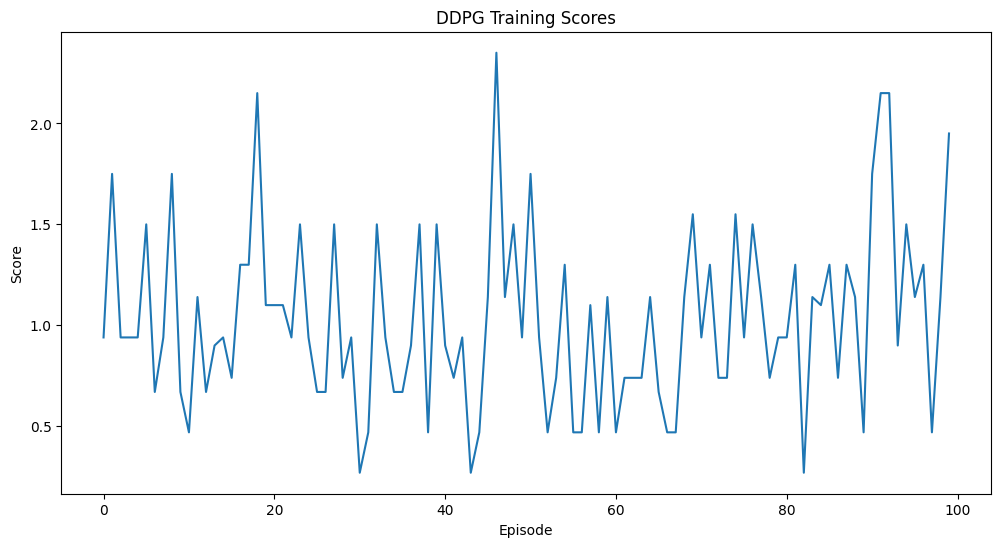

In [5]:

# Main function to train DDPG with security metrics in SFC deployment
def train_ddpg(agent, num_episodes=100, batch_size=64):
    env = SFCEnvWithSecurity()
    scores = []
    for episode in range(num_episodes):
        state = env.reset()
        episode_reward = 0
        done = False
        while not done:
            action = agent.select_action(state)
            vnf = generate_sfc()[0]  # Select a random VNF
            next_state, reward, done = env.step(action, vnf, generate_sfc())
            agent.replay_buffer.add((state, action, reward, next_state, int(done)))
            episode_reward += reward

            if len(agent.replay_buffer.buffer) > batch_size:
                agent.update(batch_size)

            state = next_state

        scores.append(episode_reward)
        print(f"Episode {episode + 1}, Score: {episode_reward:.2f}")

    return scores

if __name__ == "__main__":
    state_dim = 4
    action_dim = 1
    agent = DDPGAgent(state_dim, action_dim)
    scores = train_ddpg(agent)

    # Plotting the results
    plt.figure(figsize=(12, 6))
    plt.plot(scores)
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.title('DDPG Training Scores')
    plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Imported necessary libraries and defined static data.
Initialized DDPG agent.
Generated physical network: {1: {'remaining_capacity': 300, 'security_level': 7, 'cost': 50}, 2: {'remaining_capacity': 400, 'security_level': 6, 'cost': 40}, 3: {'remaining_capacity': 200, 'security_level': 8, 'cost': 30}, 4: {'remaining_capacity': 350, 'security_level': 5, 'cost': 20}, 5: {'remaining_capacity': 450, 'security_level': 9, 'cost': 60}, 6: {'remaining_capacity': 500, 'security_level': 10, 'cost': 70}}
Generated SFC: [{'vnf_id': 4, 'required_security_level': 8, 'processing_demand': 40}, {'vnf_id': 2, 'required_security_level': 6, 'processing_demand': 50}, {'vnf_id': 3, 'required_security_level': 7, 'processing_demand': 20}, {'vnf_id': 1, 'required_security_level': 5, 'processing_demand': 30}]
Initialized environment with network and SFC chain.
Environment reset.

Starting episode 1/100
Selected action: 3
Failed to deploy VNF 4 on Datacenter 4 due to constraints
Stored experience in replay buffer

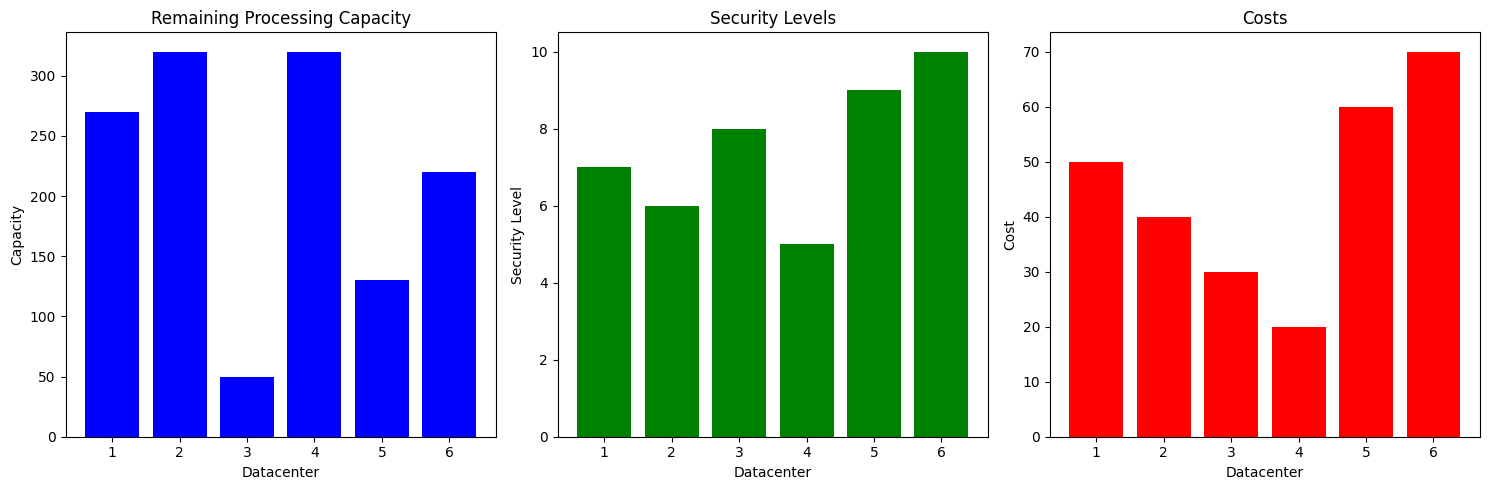

In [6]:
import gym
from gym import spaces
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import deque

# Static Data for Physical Network
STATIC_NETWORK_DATA = {
    1: {'initial_capacity': 300, 'initial_security_level': 7, 'initial_cost': 50},
    2: {'initial_capacity': 400, 'initial_security_level': 6, 'initial_cost': 40},
    3: {'initial_capacity': 200, 'initial_security_level': 8, 'initial_cost': 30},
    4: {'initial_capacity': 350, 'initial_security_level': 5, 'initial_cost': 20},
    5: {'initial_capacity': 450, 'initial_security_level': 9, 'initial_cost': 60},
    6: {'initial_capacity': 500, 'initial_security_level': 10, 'initial_cost': 70},
}

# Static Data for VNFs
STATIC_VNF_DATA = [
    {'vnf_id': 1, 'required_security_level': 5, 'processing_demand': 30},
    {'vnf_id': 2, 'required_security_level': 6, 'processing_demand': 50},
    {'vnf_id': 3, 'required_security_level': 7, 'processing_demand': 20},
    {'vnf_id': 4, 'required_security_level': 8, 'processing_demand': 40},
    {'vnf_id': 5, 'required_security_level': 9, 'processing_demand': 60},
]

print("Imported necessary libraries and defined static data.")

# Generate the Physical Network
def generate_physical_network(static_data):
    network = {}
    for node_id, attributes in static_data.items():
        network[node_id] = {
            'remaining_capacity': attributes['initial_capacity'],
            'security_level': attributes['initial_security_level'],
            'cost': attributes['initial_cost']
        }
    print("Generated physical network:", network)
    return network

# Generate the SFCs
def generate_sfc(static_vnf_data):
    sfc = random.sample(static_vnf_data, random.randint(2, 5))
    print("Generated SFC:", sfc)
    return sfc

# Environment class
class SFCEnvWithSecurity(gym.Env):
    def __init__(self, network, sfc_chain):
        super(SFCEnvWithSecurity, self).__init__()
        self.action_space = spaces.Discrete(len(network))
        self.observation_space = spaces.Box(low=0, high=500, shape=(3,), dtype=np.float32)

        self.network = network
        self.sfc_chain = sfc_chain
        self.current_vnf_index = 0
        self.SFCDeadline = 40
        print("Initialized environment with network and SFC chain.")

    def step(self, action):
        done = False
        vnf = self.sfc_chain[self.current_vnf_index]
        node = self.network[action + 1]

        if node['remaining_capacity'] >= vnf['processing_demand'] and node['security_level'] >= vnf['required_security_level']:
            node['remaining_capacity'] -= vnf['processing_demand']
            reward = 1
            print(f"Successfully deployed VNF {vnf['vnf_id']} on Datacenter {action + 1}")
        else:
            reward = -1
            print(f"Failed to deploy VNF {vnf['vnf_id']} on Datacenter {action + 1} due to constraints")

        self.current_vnf_index += 1
        if self.current_vnf_index >= len(self.sfc_chain) or self.SFCDeadline <= 0:
            done = True

        state = self.get_state(action)
        return state, reward, done

    def reset(self):
        self.current_vnf_index = 0
        self.SFCDeadline = 40
        print("Environment reset.")
        return self.get_state(0)

    def get_state(self, action):
        node = self.network[action + 1]
        return np.array([node['remaining_capacity'], node['security_level'], node['cost']], dtype=np.float32)

# DDPG Agent class
class DDPGAgent:
    def __init__(self, state_dim, action_dim, replay_buffer_size=10000):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.replay_buffer = deque(maxlen=replay_buffer_size)
        print("Initialized DDPG agent.")

    def remember(self, state, action, reward, next_state, done):
        self.replay_buffer.append((state, action, reward, next_state, done))
        print("Stored experience in replay buffer.")

    def train(self):
        if len(self.replay_buffer) < 64:
            print("Not enough experiences to train.")
            return
        batch = random.sample(self.replay_buffer, 64)
        print("Training on batch of experiences.")

    def select_action(self, state):
        action = random.randint(0, self.action_dim - 1)  # Simple random action
        print(f"Selected action: {action}")
        return action

# Visualization function
def visualize_network(network):
    nodes = list(network.keys())
    remaining_capacity = [network[node]['remaining_capacity'] for node in nodes]
    security_levels = [network[node]['security_level'] for node in nodes]
    costs = [network[node]['cost'] for node in nodes]

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

    ax1.bar(nodes, remaining_capacity, color='blue')
    ax1.set_title('Remaining Processing Capacity')
    ax1.set_xlabel('Datacenter')
    ax1.set_ylabel('Capacity')

    ax2.bar(nodes, security_levels, color='green')
    ax2.set_title('Security Levels')
    ax2.set_xlabel('Datacenter')
    ax2.set_ylabel('Security Level')

    ax3.bar(nodes, costs, color='red')
    ax3.set_title('Costs')
    ax3.set_xlabel('Datacenter')
    ax3.set_ylabel('Cost')

    plt.tight_layout()
    plt.show()

# Training function
def train_agent(agent, num_episodes):
    physical_network = generate_physical_network(STATIC_NETWORK_DATA)

    for episode in range(num_episodes):
        sfc_chain = generate_sfc(STATIC_VNF_DATA)
        env = SFCEnvWithSecurity(physical_network.copy(), sfc_chain)
        state = env.reset()

        print(f"\nStarting episode {episode + 1}/{num_episodes}")
        for _ in range(len(sfc_chain)):
            action = agent.select_action(state)
            next_state, reward, done = env.step(action)
            agent.remember(state, action, reward, next_state, done)
            agent.train()
            state = next_state
            if done:
                break

# Deployment function
def deploy_agent(agent):
    print("\nDeployment Phase:")
    physical_network_deployment = generate_physical_network(STATIC_NETWORK_DATA)
    for _ in range(10):
        sfc_chain = generate_sfc(STATIC_VNF_DATA)
        env = SFCEnvWithSecurity(physical_network_deployment.copy(), sfc_chain)
        state = env.reset()

        for _ in range(len(sfc_chain)):
            action = agent.select_action(state)
            next_state, reward, done = env.step(action)
            state = next_state
            if done:
                break

    return physical_network_deployment

# Main function
def main():
    agent = DDPGAgent(state_dim=3, action_dim=len(STATIC_NETWORK_DATA))
    train_agent(agent, num_episodes=100)  # Set to 100 episodes

    physical_network_after_deployment = deploy_agent(agent)

    print("\nUpdated Physical Machine Attributes after Deployment:")
    for node_id, node_attr in physical_network_after_deployment.items():
        print(f"Datacenter {node_id}: {{'Remaining_Proc_capacity': {node_attr['remaining_capacity']}, "
              f"'Security_level': {node_attr['security_level']}, 'Cost': {node_attr['cost']}}}")

    print("\nVisualizing Updated Network After Deployment:")
    visualize_network(physical_network_after_deployment)

if __name__ == "__main__":
    main()


Generated physical network: {1: {'remaining_capacity': 300, 'security_level': 7, 'cost': 50, 'deployed_vnfs': []}, 2: {'remaining_capacity': 400, 'security_level': 6, 'cost': 40, 'deployed_vnfs': []}, 3: {'remaining_capacity': 200, 'security_level': 8, 'cost': 30, 'deployed_vnfs': []}, 4: {'remaining_capacity': 350, 'security_level': 5, 'cost': 20, 'deployed_vnfs': []}, 5: {'remaining_capacity': 450, 'security_level': 9, 'cost': 60, 'deployed_vnfs': []}, 6: {'remaining_capacity': 500, 'security_level': 10, 'cost': 70, 'deployed_vnfs': []}}
Initialized environment with network and SFC chain.
Initialized DDPG agent.

Episode 1
Environment reset.
Selected action: 1
Failed to deploy VNF 4 on Datacenter 2 due to constraints
Stored experience in replay buffer.
Not enough experiences to train.
Selected action: 3
Successfully deployed VNF 1 on Datacenter 4 with reward 33.0
Stored experience in replay buffer.
Not enough experiences to train.
Selected action: 1
Successfully deployed VNF 2 on Dat

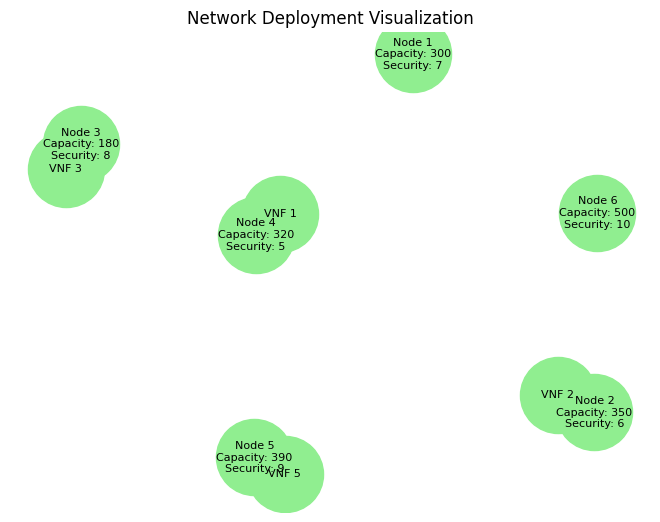


Episode 2
Environment reset.
Selected action: 0
Failed to deploy VNF 4 on Datacenter 1 due to constraints
Stored experience in replay buffer.
Not enough experiences to train.
Selected action: 5
Successfully deployed VNF 1 on Datacenter 6 with reward 49.0
Stored experience in replay buffer.
Not enough experiences to train.
Selected action: 0
Successfully deployed VNF 2 on Datacenter 1 with reward 26.4
Stored experience in replay buffer.
Not enough experiences to train.
Selected action: 2
Failed to deploy VNF 5 on Datacenter 3 due to constraints
Stored experience in replay buffer.
Not enough experiences to train.
Selected action: 5
Successfully deployed VNF 3 on Datacenter 6 with reward 47.0
Stored experience in replay buffer.
Not enough experiences to train.
Episode reward: 120.4


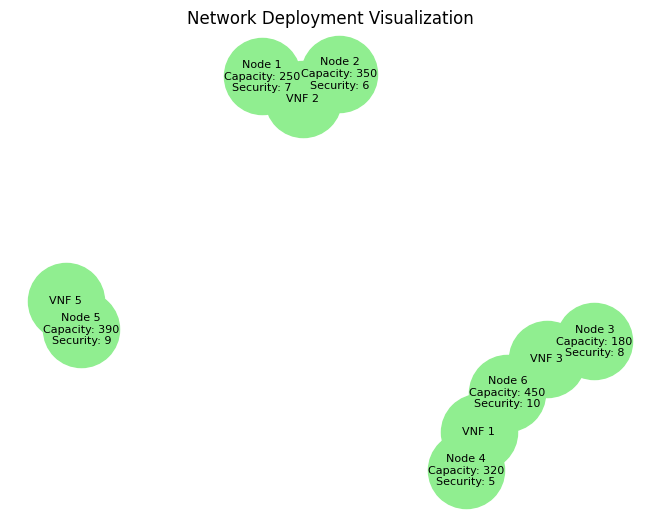


Episode 3
Environment reset.
Selected action: 0
Failed to deploy VNF 4 on Datacenter 1 due to constraints
Stored experience in replay buffer.
Not enough experiences to train.
Selected action: 3
Successfully deployed VNF 1 on Datacenter 4 with reward 30.0
Stored experience in replay buffer.
Not enough experiences to train.
Selected action: 0
Successfully deployed VNF 2 on Datacenter 1 with reward 21.4
Stored experience in replay buffer.
Not enough experiences to train.
Selected action: 4
Successfully deployed VNF 5 on Datacenter 5 with reward 34.8
Stored experience in replay buffer.
Not enough experiences to train.
Selected action: 3
Failed to deploy VNF 3 on Datacenter 4 due to constraints
Stored experience in replay buffer.
Not enough experiences to train.
Episode reward: 84.19999999999999


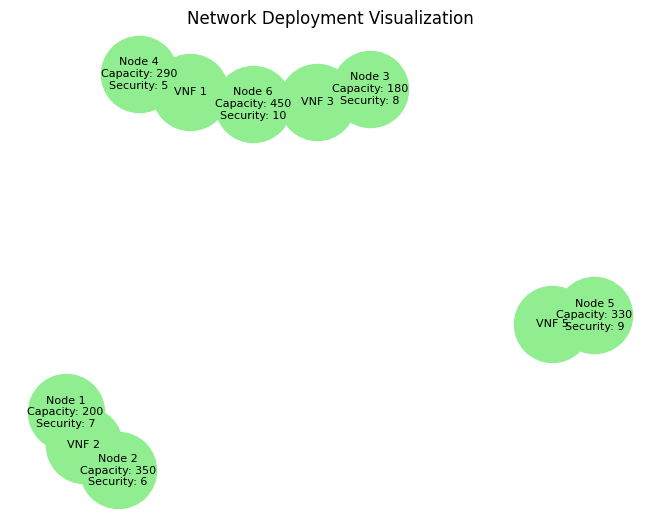


Episode 4
Environment reset.
Selected action: 0
Failed to deploy VNF 4 on Datacenter 1 due to constraints
Stored experience in replay buffer.
Not enough experiences to train.
Selected action: 2
Successfully deployed VNF 1 on Datacenter 3 with reward 16.6
Stored experience in replay buffer.
Not enough experiences to train.
Selected action: 4
Successfully deployed VNF 2 on Datacenter 5 with reward 29.8
Stored experience in replay buffer.
Not enough experiences to train.
Selected action: 2
Failed to deploy VNF 5 on Datacenter 3 due to constraints
Stored experience in replay buffer.
Not enough experiences to train.
Selected action: 0
Successfully deployed VNF 3 on Datacenter 1 with reward 19.4
Stored experience in replay buffer.
Not enough experiences to train.
Episode reward: 63.800000000000004


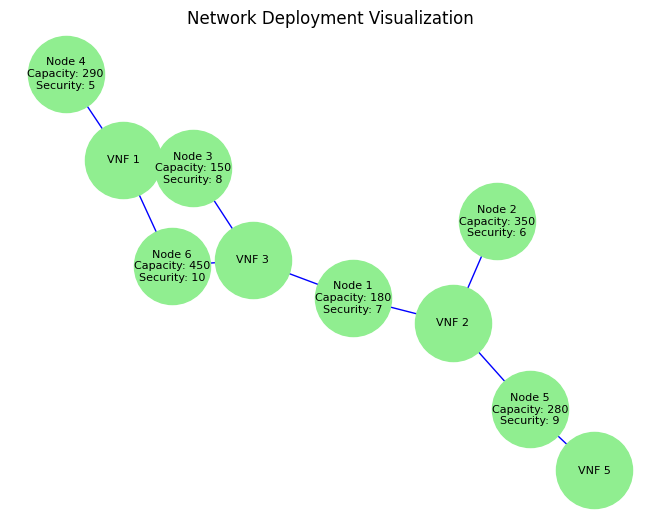


Episode 5
Environment reset.
Selected action: 0
Failed to deploy VNF 4 on Datacenter 1 due to constraints
Stored experience in replay buffer.
Not enough experiences to train.
Selected action: 2
Successfully deployed VNF 1 on Datacenter 3 with reward 13.6
Stored experience in replay buffer.
Not enough experiences to train.
Selected action: 0
Successfully deployed VNF 2 on Datacenter 1 with reward 14.4
Stored experience in replay buffer.
Not enough experiences to train.
Selected action: 4
Successfully deployed VNF 5 on Datacenter 5 with reward 23.8
Stored experience in replay buffer.
Not enough experiences to train.
Selected action: 1
Failed to deploy VNF 3 on Datacenter 2 due to constraints
Stored experience in replay buffer.
Not enough experiences to train.
Episode reward: 49.8


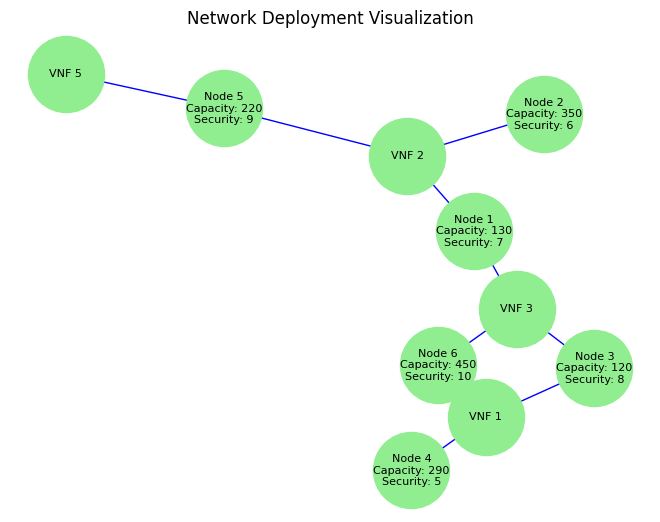


Episode 6
Environment reset.
Selected action: 0
Failed to deploy VNF 4 on Datacenter 1 due to constraints
Stored experience in replay buffer.
Not enough experiences to train.
Selected action: 0
Successfully deployed VNF 1 on Datacenter 1 with reward 11.4
Stored experience in replay buffer.
Not enough experiences to train.
Selected action: 5
Successfully deployed VNF 2 on Datacenter 6 with reward 42.0
Stored experience in replay buffer.
Not enough experiences to train.
Selected action: 4
Successfully deployed VNF 5 on Datacenter 5 with reward 17.8
Stored experience in replay buffer.
Not enough experiences to train.
Selected action: 1
Failed to deploy VNF 3 on Datacenter 2 due to constraints
Stored experience in replay buffer.
Not enough experiences to train.
Episode reward: 69.2


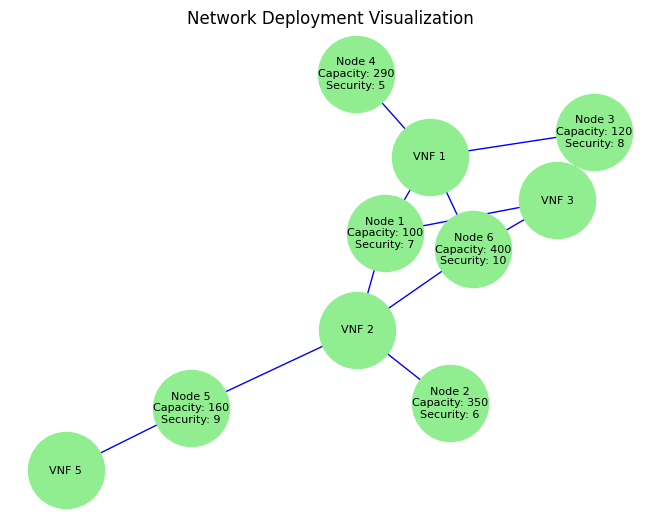


Episode 7
Environment reset.
Selected action: 3
Failed to deploy VNF 4 on Datacenter 4 due to constraints
Stored experience in replay buffer.
Not enough experiences to train.
Selected action: 0
Successfully deployed VNF 1 on Datacenter 1 with reward 8.4
Stored experience in replay buffer.
Not enough experiences to train.
Selected action: 4
Successfully deployed VNF 2 on Datacenter 5 with reward 12.8
Stored experience in replay buffer.
Not enough experiences to train.
Selected action: 1
Failed to deploy VNF 5 on Datacenter 2 due to constraints
Stored experience in replay buffer.
Not enough experiences to train.
Selected action: 4
Successfully deployed VNF 3 on Datacenter 5 with reward 10.8
Stored experience in replay buffer.
Not enough experiences to train.
Episode reward: 30.000000000000004


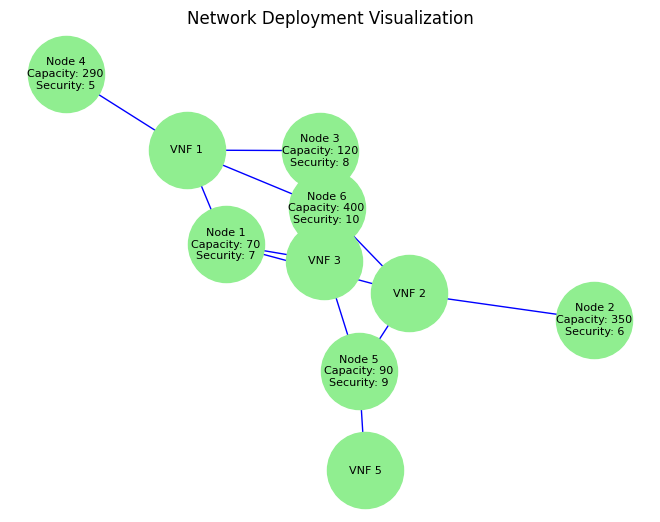


Episode 8
Environment reset.
Selected action: 5
Successfully deployed VNF 4 on Datacenter 6 with reward 38.0
Stored experience in replay buffer.
Not enough experiences to train.
Selected action: 1
Successfully deployed VNF 1 on Datacenter 2 with reward 33.2
Stored experience in replay buffer.
Not enough experiences to train.
Selected action: 5
Successfully deployed VNF 2 on Datacenter 6 with reward 33.0
Stored experience in replay buffer.
Not enough experiences to train.
Selected action: 4
Successfully deployed VNF 5 on Datacenter 5 with reward 4.8
Stored experience in replay buffer.
Not enough experiences to train.
Selected action: 4
Successfully deployed VNF 3 on Datacenter 5 with reward 2.8
Stored experience in replay buffer.
Not enough experiences to train.
Episode reward: 111.8


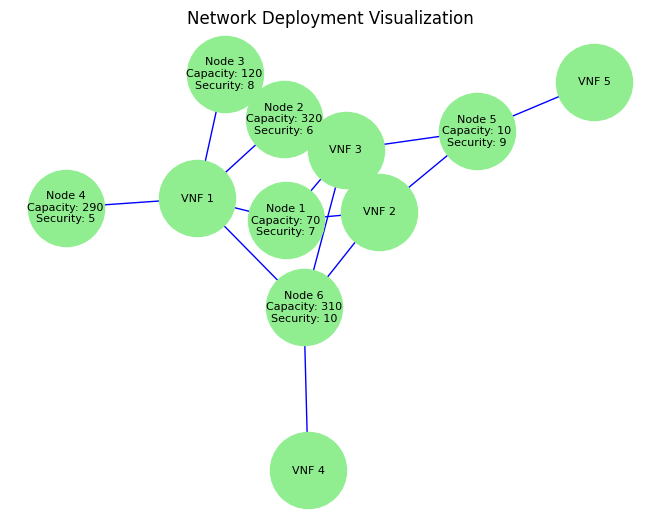


Episode 9
Environment reset.
Selected action: 3
Failed to deploy VNF 4 on Datacenter 4 due to constraints
Stored experience in replay buffer.
Not enough experiences to train.
Selected action: 0
Successfully deployed VNF 1 on Datacenter 1 with reward 5.4
Stored experience in replay buffer.
Not enough experiences to train.
Selected action: 1
Successfully deployed VNF 2 on Datacenter 2 with reward 28.2
Stored experience in replay buffer.
Not enough experiences to train.
Selected action: 0
Failed to deploy VNF 5 on Datacenter 1 due to constraints
Stored experience in replay buffer.
Not enough experiences to train.
Selected action: 0
Successfully deployed VNF 3 on Datacenter 1 with reward 3.4000000000000004
Stored experience in replay buffer.
Not enough experiences to train.
Episode reward: 35.0


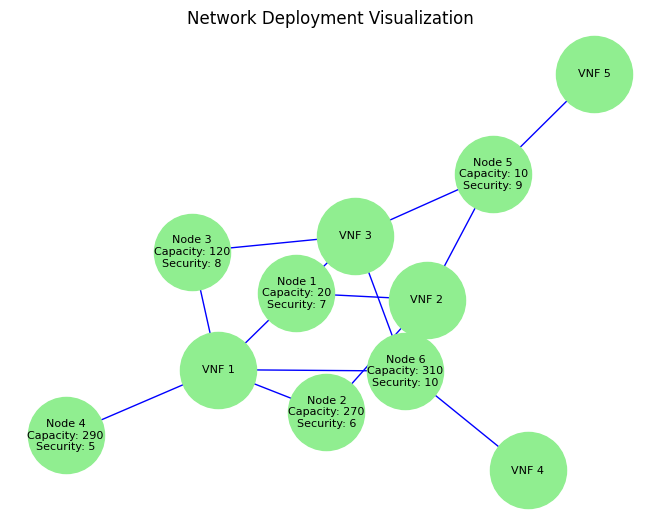


Episode 10
Environment reset.
Selected action: 4
Failed to deploy VNF 4 on Datacenter 5 due to constraints
Stored experience in replay buffer.
Not enough experiences to train.
Selected action: 2
Successfully deployed VNF 1 on Datacenter 3 with reward 10.6
Stored experience in replay buffer.
Not enough experiences to train.
Selected action: 4
Failed to deploy VNF 2 on Datacenter 5 due to constraints
Stored experience in replay buffer.
Not enough experiences to train.
Selected action: 2
Failed to deploy VNF 5 on Datacenter 3 due to constraints
Stored experience in replay buffer.
Not enough experiences to train.
Selected action: 4
Failed to deploy VNF 3 on Datacenter 5 due to constraints
Stored experience in replay buffer.
Not enough experiences to train.
Episode reward: 6.6


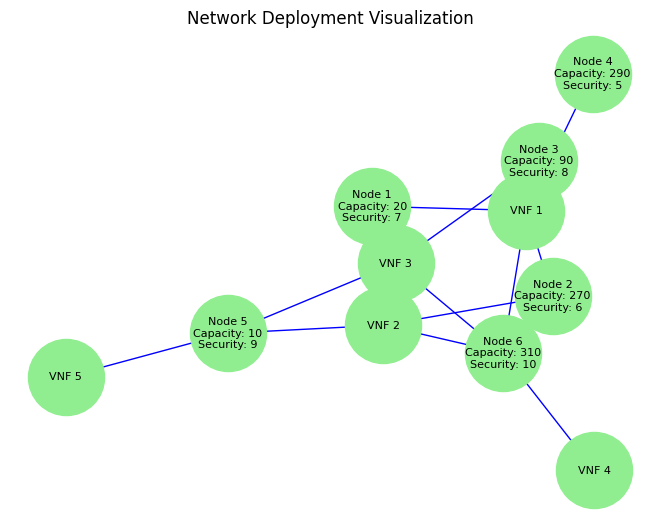


Episode 11
Environment reset.
Selected action: 4
Failed to deploy VNF 4 on Datacenter 5 due to constraints
Stored experience in replay buffer.
Not enough experiences to train.
Selected action: 0
Failed to deploy VNF 1 on Datacenter 1 due to constraints
Stored experience in replay buffer.
Not enough experiences to train.
Selected action: 4
Failed to deploy VNF 2 on Datacenter 5 due to constraints
Stored experience in replay buffer.
Not enough experiences to train.
Selected action: 4
Failed to deploy VNF 5 on Datacenter 5 due to constraints
Stored experience in replay buffer.
Not enough experiences to train.
Selected action: 0
Successfully deployed VNF 3 on Datacenter 1 with reward 1.4000000000000001
Stored experience in replay buffer.
Not enough experiences to train.
Episode reward: -2.5999999999999996


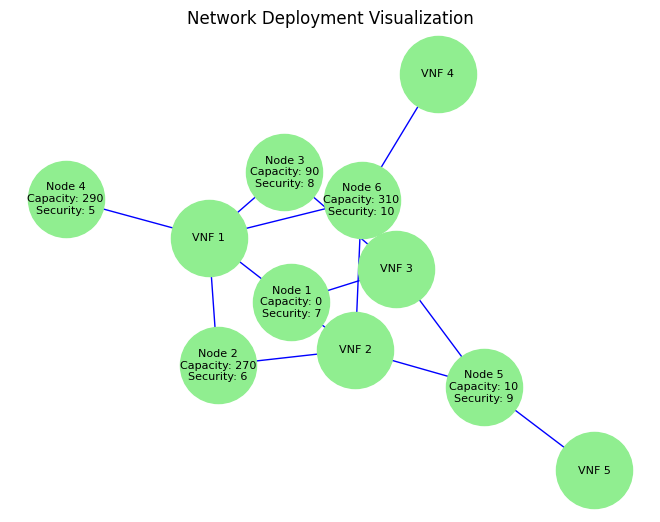


Episode 12
Environment reset.
Selected action: 4
Failed to deploy VNF 4 on Datacenter 5 due to constraints
Stored experience in replay buffer.
Not enough experiences to train.
Selected action: 4
Failed to deploy VNF 1 on Datacenter 5 due to constraints
Stored experience in replay buffer.
Not enough experiences to train.
Selected action: 1
Successfully deployed VNF 2 on Datacenter 2 with reward 23.2
Stored experience in replay buffer.
Not enough experiences to train.
Selected action: 3
Failed to deploy VNF 5 on Datacenter 4 due to constraints
Stored experience in replay buffer.
Not enough experiences to train.
Selected action: 3
Failed to deploy VNF 3 on Datacenter 4 due to constraints
Stored experience in replay buffer.
Not enough experiences to train.
Episode reward: 19.2


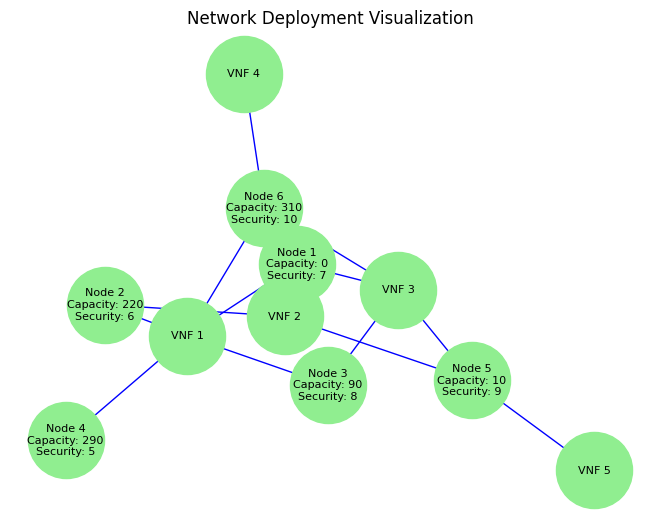


Episode 13
Environment reset.
Selected action: 0
Failed to deploy VNF 4 on Datacenter 1 due to constraints
Stored experience in replay buffer.
Not enough experiences to train.
Selected action: 3
Successfully deployed VNF 1 on Datacenter 4 with reward 27.0
Stored experience in replay buffer.
Not enough experiences to train.
Selected action: 2
Successfully deployed VNF 2 on Datacenter 3 with reward 5.6
Stored experience in replay buffer.
Not enough experiences to train.
Selected action: 1
Failed to deploy VNF 5 on Datacenter 2 due to constraints
Stored experience in replay buffer.
Training on batch of experiences.
Selected action: 2
Successfully deployed VNF 3 on Datacenter 3 with reward 3.6
Stored experience in replay buffer.
Training on batch of experiences.
Episode reward: 34.2


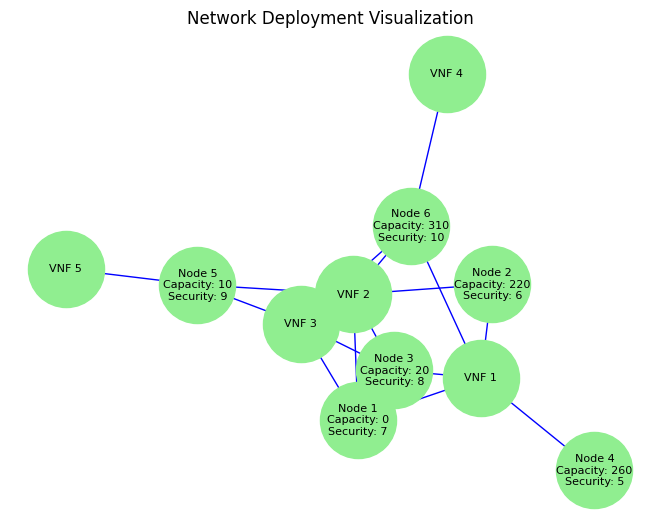


Episode 14
Environment reset.
Selected action: 2
Failed to deploy VNF 4 on Datacenter 3 due to constraints
Stored experience in replay buffer.
Training on batch of experiences.
Selected action: 0
Failed to deploy VNF 1 on Datacenter 1 due to constraints
Stored experience in replay buffer.
Training on batch of experiences.
Selected action: 4
Failed to deploy VNF 2 on Datacenter 5 due to constraints
Stored experience in replay buffer.
Training on batch of experiences.
Selected action: 5
Successfully deployed VNF 5 on Datacenter 6 with reward 27.0
Stored experience in replay buffer.
Training on batch of experiences.
Selected action: 0
Failed to deploy VNF 3 on Datacenter 1 due to constraints
Stored experience in replay buffer.
Training on batch of experiences.
Episode reward: 23.0


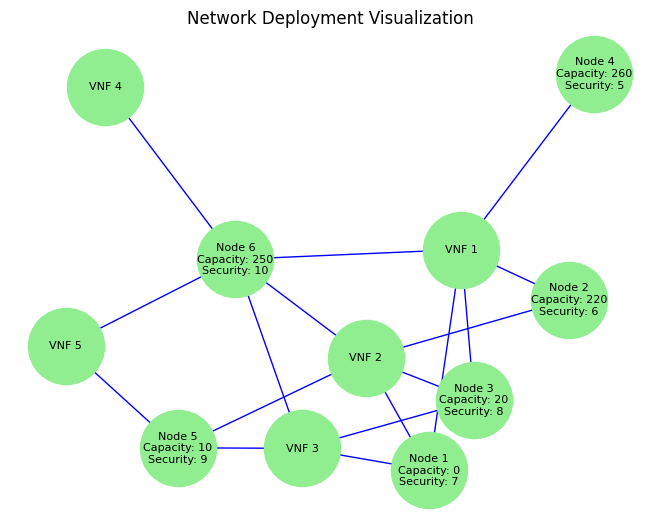


Episode 15
Environment reset.
Selected action: 4
Failed to deploy VNF 4 on Datacenter 5 due to constraints
Stored experience in replay buffer.
Training on batch of experiences.
Selected action: 3
Successfully deployed VNF 1 on Datacenter 4 with reward 24.0
Stored experience in replay buffer.
Training on batch of experiences.
Selected action: 2
Failed to deploy VNF 2 on Datacenter 3 due to constraints
Stored experience in replay buffer.
Training on batch of experiences.
Selected action: 4
Failed to deploy VNF 5 on Datacenter 5 due to constraints
Stored experience in replay buffer.
Training on batch of experiences.
Selected action: 2
Successfully deployed VNF 3 on Datacenter 3 with reward 1.6
Stored experience in replay buffer.
Training on batch of experiences.
Episode reward: 22.6


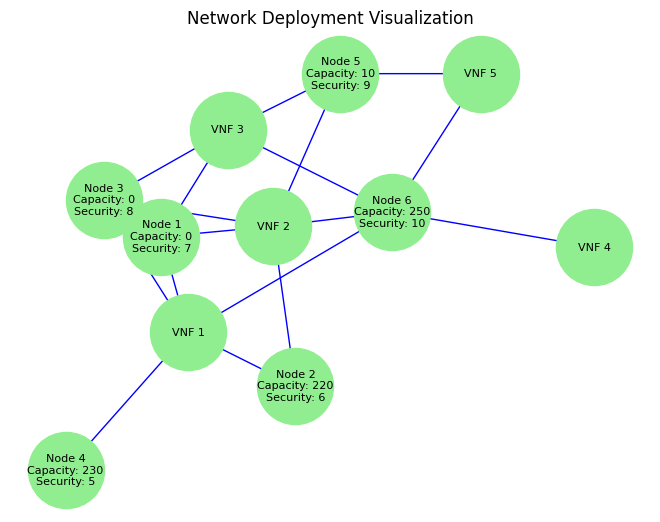


Episode 16
Environment reset.
Selected action: 2
Failed to deploy VNF 4 on Datacenter 3 due to constraints
Stored experience in replay buffer.
Training on batch of experiences.
Selected action: 2
Failed to deploy VNF 1 on Datacenter 3 due to constraints
Stored experience in replay buffer.
Training on batch of experiences.
Selected action: 5
Successfully deployed VNF 2 on Datacenter 6 with reward 22.0
Stored experience in replay buffer.
Training on batch of experiences.
Selected action: 4
Failed to deploy VNF 5 on Datacenter 5 due to constraints
Stored experience in replay buffer.
Training on batch of experiences.
Selected action: 0
Failed to deploy VNF 3 on Datacenter 1 due to constraints
Stored experience in replay buffer.
Training on batch of experiences.
Episode reward: 18.0


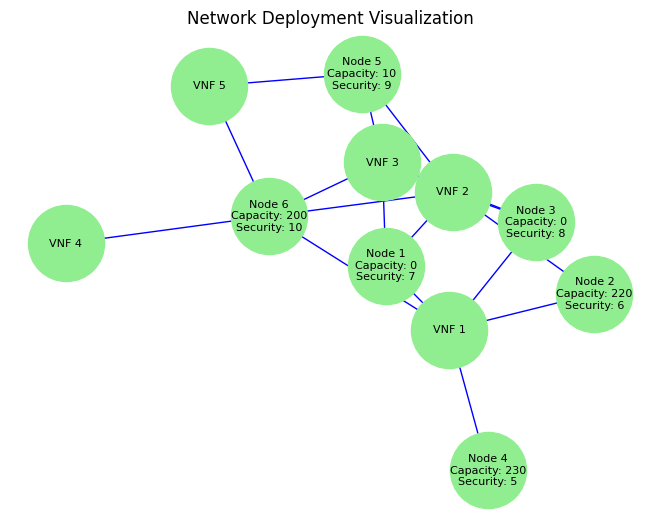


Episode 17
Environment reset.
Selected action: 4
Failed to deploy VNF 4 on Datacenter 5 due to constraints
Stored experience in replay buffer.
Training on batch of experiences.
Selected action: 4
Failed to deploy VNF 1 on Datacenter 5 due to constraints
Stored experience in replay buffer.
Training on batch of experiences.
Selected action: 3
Failed to deploy VNF 2 on Datacenter 4 due to constraints
Stored experience in replay buffer.
Training on batch of experiences.
Selected action: 2
Failed to deploy VNF 5 on Datacenter 3 due to constraints
Stored experience in replay buffer.
Training on batch of experiences.
Selected action: 1
Failed to deploy VNF 3 on Datacenter 2 due to constraints
Stored experience in replay buffer.
Training on batch of experiences.
Episode reward: -5


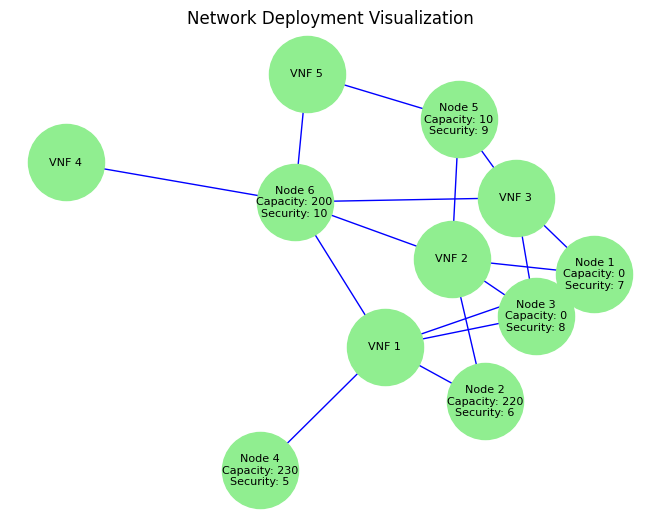


Episode 18
Environment reset.
Selected action: 5
Successfully deployed VNF 4 on Datacenter 6 with reward 18.0
Stored experience in replay buffer.
Training on batch of experiences.
Selected action: 5
Successfully deployed VNF 1 on Datacenter 6 with reward 15.0
Stored experience in replay buffer.
Training on batch of experiences.
Selected action: 4
Failed to deploy VNF 2 on Datacenter 5 due to constraints
Stored experience in replay buffer.
Training on batch of experiences.
Selected action: 2
Failed to deploy VNF 5 on Datacenter 3 due to constraints
Stored experience in replay buffer.
Training on batch of experiences.
Selected action: 4
Failed to deploy VNF 3 on Datacenter 5 due to constraints
Stored experience in replay buffer.
Training on batch of experiences.
Episode reward: 30.0


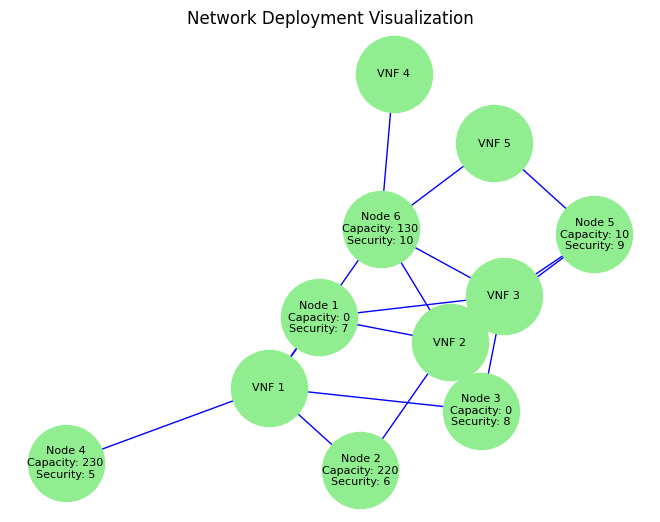


Episode 19
Environment reset.
Selected action: 5
Successfully deployed VNF 4 on Datacenter 6 with reward 11.0
Stored experience in replay buffer.
Training on batch of experiences.
Selected action: 4
Failed to deploy VNF 1 on Datacenter 5 due to constraints
Stored experience in replay buffer.
Training on batch of experiences.
Selected action: 2
Failed to deploy VNF 2 on Datacenter 3 due to constraints
Stored experience in replay buffer.
Training on batch of experiences.
Selected action: 2
Failed to deploy VNF 5 on Datacenter 3 due to constraints
Stored experience in replay buffer.
Training on batch of experiences.
Selected action: 3
Failed to deploy VNF 3 on Datacenter 4 due to constraints
Stored experience in replay buffer.
Training on batch of experiences.
Episode reward: 7.0


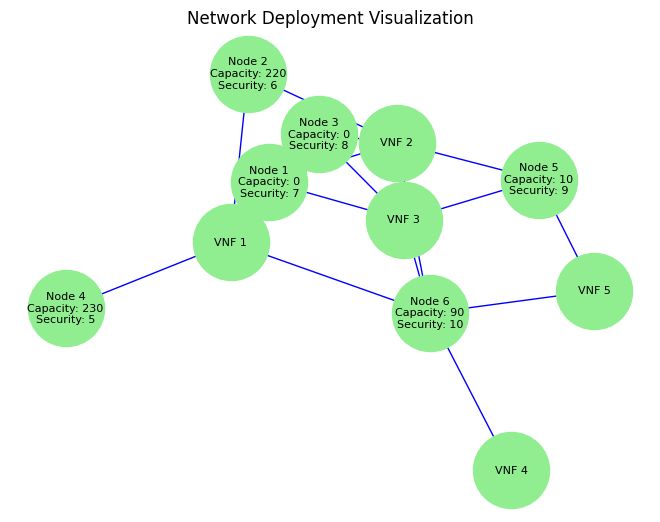


Episode 20
Environment reset.
Selected action: 4
Failed to deploy VNF 4 on Datacenter 5 due to constraints
Stored experience in replay buffer.
Training on batch of experiences.
Selected action: 0
Failed to deploy VNF 1 on Datacenter 1 due to constraints
Stored experience in replay buffer.
Training on batch of experiences.
Selected action: 4
Failed to deploy VNF 2 on Datacenter 5 due to constraints
Stored experience in replay buffer.
Training on batch of experiences.
Selected action: 5
Successfully deployed VNF 5 on Datacenter 6 with reward 5.0
Stored experience in replay buffer.
Training on batch of experiences.
Selected action: 0
Failed to deploy VNF 3 on Datacenter 1 due to constraints
Stored experience in replay buffer.
Training on batch of experiences.
Episode reward: 1.0


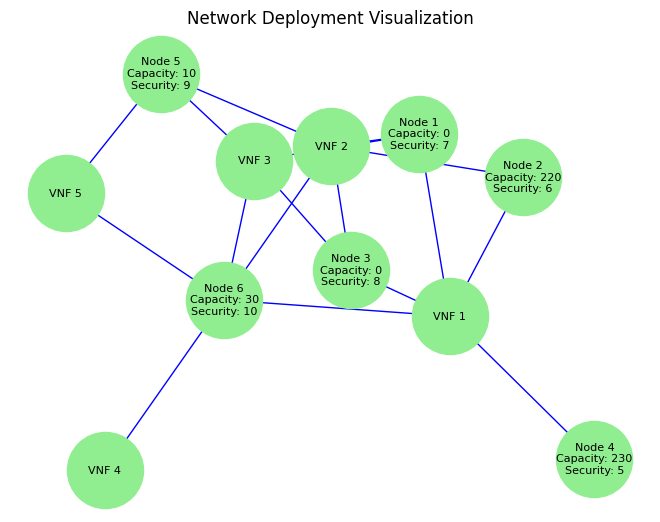

In [7]:
import gym
from gym import spaces
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import deque
import networkx as nx

# Static Data for VNFs
VNF_Info = {
    1: ['NAT', 2, 'S'],
    2: ['FW', 1, 'M'],
    3: ['TM', 1, 'S'],
    4: ['WOC', 2, 'M'],
    5: ['IDPS', 4, 'S'],
    6: ['VOC', 4, 'M'],
    7: ['VPN', 2, 'M'],
    8: ['LB', 2, 'M'],
    9: ['DPI', 4, 'S'],
    10: ['P', 1, 'M'],
    11: ['TS', 2, 'M'],
    12: ['C', 4, 'S'],
    13: ['SFW', 1, 'S'],
    14: ['EFW', 4, 'M']
}

# Static Data for SFCs
SFC_Chains = [
    [1, 2, 3, 4, 5],
    [1, 2, 3, 2, 1],
    [1, 2, 3, 6, 5],
    [1, 2, 6, 4, 5],
    [7, 3, 2, 8],
    [14],
    [14, 8],
    [14, 8, 2],
    [4, 13, 8, 2],
    [4, 14, 3, 8, 2],
    [13, 8, 3, 2]
]

# Generate the Physical Network
def generate_physical_network(static_data):
    network = {}
    for node_id, attributes in static_data.items():
        network[node_id] = {
            'remaining_capacity': attributes['initial_capacity'],
            'security_level': attributes['initial_security_level'],
            'cost': attributes['initial_cost'],
            'deployed_vnfs': []  # To track deployed VNFs
        }
    print("Generated physical network:", network)
    return network

# Environment class
class SFCEnvWithSecurity(gym.Env):
    def __init__(self, network, sfc_chain):
        super(SFCEnvWithSecurity, self).__init__()
        self.action_space = spaces.Discrete(len(network))
        self.observation_space = spaces.Box(low=0, high=500, shape=(3,), dtype=np.float32)

        self.network = network
        self.sfc_chain = sfc_chain
        self.current_vnf_index = 0
        self.SFCDeadline = 40
        print("Initialized environment with network and SFC chain.")

    def step(self, action):
        done = False
        vnf = self.sfc_chain[self.current_vnf_index]
        node_id = action + 1  # Adjust action to match node ID in network

        if node_id in self.network:
            node = self.network[node_id]
            if node['remaining_capacity'] >= vnf['processing_demand'] and node['security_level'] >= vnf['required_security_level']:
                node['remaining_capacity'] -= vnf['processing_demand']
                node['deployed_vnfs'].append(vnf['vnf_id'])  # Track deployed VNF
                reward = node['remaining_capacity'] * 0.1 + node['security_level'] * 0.2
                print(f"Successfully deployed VNF {vnf['vnf_id']} on Datacenter {node_id} with reward {reward}")
            else:
                reward = -1
                print(f"Failed to deploy VNF {vnf['vnf_id']} on Datacenter {node_id} due to constraints")
        else:
            reward = -1
            print(f"Invalid action: Datacenter {node_id} does not exist.")

        self.current_vnf_index += 1
        if self.current_vnf_index >= len(self.sfc_chain) or self.SFCDeadline <= 0:
            done = True

        state = self.get_state(action)
        return state, reward, done

    def reset(self):
        self.current_vnf_index = 0
        self.SFCDeadline = 40
        print("Environment reset.")
        return self.get_state(0)

    def get_state(self, action):
        node_id = action + 1  # Adjust action to match node ID in network
        node = self.network[node_id]
        return np.array([node['remaining_capacity'], node['security_level'], node['cost']], dtype=np.float32)

# Visualization function
def visualize_deployment(network):
    G = nx.Graph()
    for node_id, attributes in network.items():
        G.add_node(node_id, label=f"Node {node_id}\nCapacity: {attributes['remaining_capacity']}\nSecurity: {attributes['security_level']}")
        for vnf in attributes['deployed_vnfs']:
            G.add_node(f'VNF {vnf}', label=f'VNF {vnf}')
            G.add_edge(node_id, f'VNF {vnf}', color='blue')  # Edge color for VNF deployment

    pos = nx.spring_layout(G)
    labels = nx.get_node_attributes(G, 'label')
    colors = [G[u][v]['color'] if G.has_edge(u, v) else 'grey' for u, v in G.edges()]

    nx.draw(G, pos, with_labels=True, labels=labels, node_size=3000, node_color='lightgreen', edge_color=colors, font_size=8)
    plt.title("Network Deployment Visualization")
    plt.show()

# Main loop
STATIC_NETWORK_DATA = {
    1: {'initial_capacity': 300, 'initial_security_level': 7, 'initial_cost': 50},
    2: {'initial_capacity': 400, 'initial_security_level': 6, 'initial_cost': 40},
    3: {'initial_capacity': 200, 'initial_security_level': 8, 'initial_cost': 30},
    4: {'initial_capacity': 350, 'initial_security_level': 5, 'initial_cost': 20},
    5: {'initial_capacity': 450, 'initial_security_level': 9, 'initial_cost': 60},
    6: {'initial_capacity': 500, 'initial_security_level': 10, 'initial_cost': 70},
}

STATIC_VNF_DATA = [
    {'vnf_id': 1, 'required_security_level': 5, 'processing_demand': 30},
    {'vnf_id': 2, 'required_security_level': 6, 'processing_demand': 50},
    {'vnf_id': 3, 'required_security_level': 7, 'processing_demand': 20},
    {'vnf_id': 4, 'required_security_level': 8, 'processing_demand': 40},
    {'vnf_id': 5, 'required_security_level': 9, 'processing_demand': 60},
]

physical_network = generate_physical_network(STATIC_NETWORK_DATA)
sfc_chain = random.sample(STATIC_VNF_DATA, random.randint(2, 5))

env = SFCEnvWithSecurity(physical_network, sfc_chain)
agent = DDPGAgent(state_dim=3, action_dim=len(physical_network))

# Variables for visualization
# Removed the rewards list since we won't plot it

# Train for episodes
num_episodes = 20
for episode in range(num_episodes):
    print(f"\nEpisode {episode + 1}")
    state = env.reset()
    done = False
    episode_reward = 0

    while not done:
        action = agent.select_action(state)
        next_state, reward, done = env.step(action)
        agent.remember(state, action, reward, next_state, done)
        agent.train()
        state = next_state
        episode_reward += reward

    print(f"Episode reward: {episode_reward}")

    # Visualize deployment after each episode
    visualize_deployment(env.network)

# Removed the plotting of rewards
